# Variational Autoencoders (VAE)

A Variational Autoencoder (VAE) is a type of generative model that learns to generate new data samples similar to those in the training dataset. It is a type of neural network architecture that combines principles from both autoencoders and variational inference.

## How does a VAE work?

### 1. Autoencoder:

An autoencoder is a neural network architecture that consists of an encoder and a decoder. The encoder takes input data and compresses it into a latent space representation, while the decoder reconstructs the original data from this latent representation. The objective of an autoencoder is to minimize the reconstruction error between the input and the output.

### 2. Variational Inference:

Variational inference is a method used to approximate complex probability distributions. It involves introducing a variational distribution (approximation) and optimizing its parameters to make it as close as possible to the true posterior distribution.

### 3. Variational Autoencoder:

A VAE combines the concepts of an autoencoder and variational inference. Instead of learning a single latent representation for each input, a VAE learns a probability distribution (typically Gaussian) over the latent space. This is achieved by introducing two additional components:
- The encoder network maps input data to a distribution in the latent space.
- The decoder network reconstructs data samples from samples drawn from this latent distribution.

### Training a VAE:

1. **Encoder Network (Recognition Model):** Takes input data and outputs the parameters of the latent distribution (mean and variance).
2. **Sampling:** Samples latent vectors from the learned distribution.
3. **Decoder Network (Generative Model):** Takes the sampled latent vectors and generates data samples.
4. **Reconstruction Loss:** Measures the difference between the input data and the output of the decoder.
5. **KL Divergence Loss:** Measures the discrepancy between the learned latent distribution and a predefined prior distribution (often standard Gaussian).
6. **Overall Loss:** Combination of reconstruction loss and KL divergence loss.
7. **Optimization:** Update the parameters of both the encoder and decoder networks to minimize the overall loss.

## Demo: Implementing VAE on the MNIST Dataset

In this notebook, we'll demonstrate how to implement a VAE using PyTorch on the MNIST dataset. We'll walk through the steps of defining the encoder and decoder networks, designing the loss function, and training the VAE model.

## Autoencoder Network

Before delving into variational autoencoders and their properties, it's important to first look at normal autoencoders and why we use them. An autoencoder is a type of neural network designed to learn efficient codings of unlabeled data. The aim of an autoencoder is to learn a representation (encoding) for a set of data, typically for the purpose of dimensionality reduction or feature learning. Autoencoders consist of two main parts:

1. **Encoder**: This part compresses the input into a latent-space representation.
2. **Decoder**: This part reconstructs the input from the latent space.

In [2]:
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import itertools
import datetime

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

### Dataset Loading and DataLoader Definition
The follwing code snippet the workflow by downloading the MNIST dataset, a standard benchmark dataset, that contains grayscale images of handwritten digits (0-9). A training and as well as a validation set are loaded, and processed using `torch.utils.data.DataLoader`, creating `train_dl` and `val_dl`. These are DataLoader objects each with a batch size of 100. These DataLoader objects streamline data handling, facilitating seamless integration of the MNIST dataset into machine learning models.


In [ ]:
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
val_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 14951037.76it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 499036.80it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 4489541.27it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 10144051.53it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [ ]:
train_dl = torch.utils.data.DataLoader(train_dataset, batch_size=100)
val_dl = torch.utils.data.DataLoader(val_dataset, batch_size=100)

###  AutoEncoder class definition
The provided code defines an autoencoder architecture consisting of an encoder and a decoder.

- **Encoder**: The `Encoder` class takes an input image and compresses it into a lower-dimensional representation (latent space) using convolutional layers followed by fully connected layers. This compressed representation captures the essential features of the input image.

- **Decoder**: The `Decoder` class reconstructs the original input image from the compressed representation generated by the encoder. It does so by employing transpose convolutional layers, also known as deconvolutional layers, to upsample the compressed representation back to the original image dimensions.

Together, the encoder and decoder form an autoencoder network, which is trained to minimize the reconstruction error between the input and output images. This architecture can be used for various tasks, including image denoising, dimensionality reduction, and generative modeling. In this context, it will be used to reconstruct digits from the MNIST dataset.


In [ ]:
class Encoder(nn.Module):
  def __init__(self, z_dim=2):
    super().__init__()
    # 100, 1, 28, 28
    self.conv1 = nn.Conv2d(1, 8, 3, stride=2, padding=1)
    # 100, 8, 14, 14
    self.conv2 = nn.Conv2d(8, 16, 3, stride=2, padding=1)
    # 100, 16, 7, 7
    self.conv3 = nn.Conv2d(16, 32, 3, stride=2, padding=0)
    # 100, 32, 3, 3
    self.fc1 = nn.Linear(32*3*3, 128)
    self.fc2 = nn.Linear(128, z_dim)
    self.bn1 = nn.BatchNorm2d(16)

  def forward(self, x):
    out = F.relu(self.conv1(x))
    out = F.relu(self.conv2(out))
    out = self.bn1(out)
    out = F.relu(self.conv3(out))
    out = out.flatten(1)
    out = F.relu(self.fc1(out))
    out = self.fc2(out)
    return out


In [ ]:
class Decoder(nn.Module):
  def __init__(self, z_dim=2):
    super().__init__()
    self.fc3 = nn.Linear(z_dim, 128)
    self.fc4 = nn.Linear(128, 32*3*3)
    self.t_conv1 = nn.ConvTranspose2d(32, 16, 3, stride=2, output_padding=0)
    self.bn2 = nn.BatchNorm2d(16)
    self.t_conv2 = nn.ConvTranspose2d(16, 8, 3, stride=2, padding=1, output_padding=1)
    self.bn3 = nn.BatchNorm2d(8)
    self.t_conv3 = nn.ConvTranspose2d(8, 1, 3, stride=2, padding=1, output_padding=1)

  def forward(self, x):
    # 100, 4
    out = F.relu(self.fc3(x))
    # 100, 128
    out = F.relu(self.fc4(out))
    # 100, 32*3*3
    out = out.unflatten(1, (32, 3, 3))
    # 100, 32, 3, 3
    out = self.t_conv1(out)
    out = F.relu(self.bn2(out))
    # 100, 16, 7, 7
    out = self.t_conv2(out)
    out = F.relu(self.bn3(out))
    # 100, 8, 14, 14
    out = self.t_conv3(out)
    # 100, 1, 28, 28
    out = torch.sigmoid(out)
    return out



### Model Training

In the following code, a training loop is defined to train the autoencoder model on the MNIST dataset using backpropagation. The `training_loop` function iterates through the specified number of epochs, performing forward and backward passes through the model for each batch of data. During each iteration, the encoder (`enc`) compresses input images into a lower-dimensional latent space, while the decoder (`dec`) reconstructs the original images from the latent representations. The reconstruction loss, calculated using the mean squared error loss function (`nn.MSELoss()`), quantifies the difference between the original and reconstructed images and is used to update the model parameters.


In [ ]:
def training_loop(n_epochs, optimizer_enc, optimizer_dec, enc, dec, loss_fn, train_loader, val_loader):
  train_loss = []
  val_loss = []
  for epoch  in range(1, n_epochs+1):
    train_epoch_loss = 0.0
    val_epoch_loss = 0.0

    for imgs, _ in train_loader:
      imgs = imgs.to(device)
      latents = enc(imgs)
      outputs = dec(latents)
      loss_train = loss_fn(outputs, imgs)

      optimizer_enc.zero_grad()
      optimizer_dec.zero_grad()

      loss_train.backward()
      optimizer_enc.step()
      optimizer_dec.step()

      train_epoch_loss += loss_train.item()

    for imgs, _ in val_loader:
      imgs = imgs.to(device)
      outputs = dec(enc(imgs))
      loss_val = loss_fn(outputs, imgs)
      val_epoch_loss += loss_val.item()


    if epoch == 1 or epoch % 10 == 0:
      print('{} Epoch {}, Training Loss {}, Validation Loss {}'.format(datetime.datetime.now(), epoch, train_epoch_loss / len(train_loader), val_epoch_loss / len(val_loader)))

    train_loss.append(train_epoch_loss / len(train_loader))
    val_loss.append(val_epoch_loss / len(val_loader))

  return train_loss, val_loss


In [ ]:
enc = Encoder().to(device)
dec = Decoder().to(device)

num_trainable_params_enc = sum(p.numel() for p in enc.parameters() if p.requires_grad)
num_trainable_params_dec = sum(p.numel() for p in dec.parameters() if p.requires_grad)

print(f"Number of trainable parameters in Encoder: {num_trainable_params_enc}")
print(f"Number of trainable parameters in Decoder: {num_trainable_params_dec}")

Number of trainable parameters in Encoder: 43170
Number of trainable parameters in Decoder: 43441


In [ ]:
optimizer_enc = torch.optim.Adam(enc.parameters())
optimizer_dec = torch.optim.Adam(dec.parameters())

train_loss, val_loss = training_loop(
                            n_epochs = 20,
                            optimizer_enc = optimizer_enc,
                            optimizer_dec = optimizer_dec,
                            enc = enc,
                            dec = dec,
                            loss_fn = nn.MSELoss(),
                            train_loader = train_dl,
                            val_loader = val_dl
                            )

2024-05-17 16:17:11.973871 Epoch 1, Training Loss 0.30460425801575186, Validation Loss 0.2257677885890007
2024-05-17 16:18:50.642606 Epoch 10, Training Loss 0.1816077656795581, Validation Loss 0.1846328465640545
2024-05-17 16:20:37.043653 Epoch 20, Training Loss 0.17548115797340869, Validation Loss 0.17774532198905946


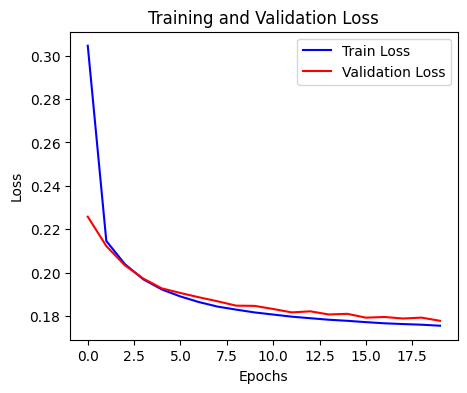

In [ ]:
plt.figure(figsize=(5, 4))
plt.plot(train_loss, label='Train Loss', color='blue')
plt.plot(val_loss, label='Validation Loss', color='red')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Generating Images

To demonstrate the generative properties of the autoencoder we just trained, we can sample from its latent space and generate images. Sampling from the latent space means selecting random points in the space where the encoder maps the input data. These points are then passed through the decoder to generate new images.

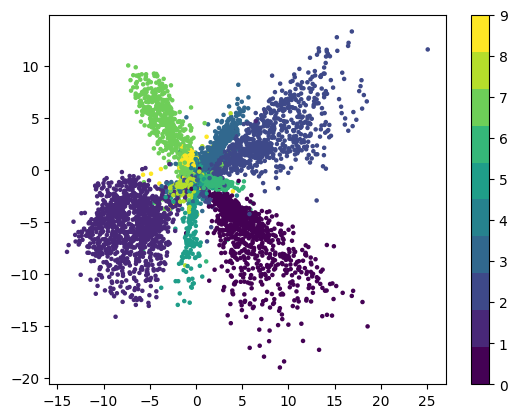

In [ ]:
values = None
all_labels = []

with torch.no_grad():
  for imgs, labels in val_dl:
    imgs = imgs.to(device)
    all_labels.extend(list(labels.numpy()))
    latents = enc(imgs)
    if values is None:
      values = latents.cpu()
    else:
      values = torch.vstack((values, latents.cpu()))


cmap = plt.get_cmap('viridis', 10)
scatter = plt.scatter(values[:, 0], values[:, 1], c=all_labels, cmap=cmap, s=5)
plt.colorbar(scatter)
plt.show()

In [ ]:
ranges = [np.linspace(-10, 10, 16),
          np.linspace(-10, 10, 16)]
samples = np.array(list(itertools.product(*ranges)))

with torch.no_grad():
  predictions = dec(torch.Tensor(samples).to(device)).cpu()
predictions.size()

torch.Size([256, 1, 28, 28])

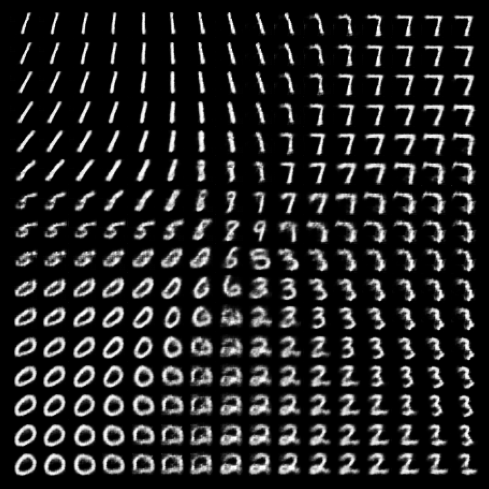

In [ ]:
n = int(np.sqrt(predictions.size(0)))
fig, ax = plt.subplots(n, n, figsize=(5, 5), gridspec_kw={'wspace': 0, 'hspace': 0}, facecolor='black')
ax_flat = ax.flatten()
for i in range(n**2):
    img = predictions[i, 0]
    ax = ax_flat[i]
    ax.imshow(img, cmap='gray')
    ax.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
# Save values for plotting later
df = pd.DataFrame({'Latent1': values[:, 0], 'Latent2': values[:, 1], 'Label': all_labels})
df.to_csv('reconstruction_loss.csv', index=False)


### Observations and Conclusion

Upon analyzing the images and the latent space plot, we can make the following observations:

- Some of the generated images are blurry and nonsensical, not resembling any recognizable number.
- The latent space lacks a coherent structure, appearing discontinuous with clusters of points and many empty spaces.

Given these observations, we can conclude that a normal autoencoder is not a generative model. It fails to produce realistic images consistently and does not learn a smooth, continuous latent space necessary for effective data generation.


### Why a Normal Autoencoder is Not a Generative Model

A normal autoencoder is designed to encode input data into a lower-dimensional latent space and then decode it back to the original data. However, it is not considered a generative model for the following reasons:

1. **Deterministic Nature**: Normal autoencoders operate deterministically. For a given input, the encoder generates a specific latent representation, and the decoder reconstructs this representation back to the original input. This means the model does not inherently generate new, diverse samples from the data distribution.

2. **Latent Space Structure**: The latent space in a normal autoencoder does not necessarily have a well-structured, continuous, and smooth distribution. This makes it difficult to sample meaningful points from the latent space that would correspond to valid data points when decoded.

3. **No Explicit Data Distribution Modeling**: Normal autoencoders do not explicitly model the data distribution. They focus on reconstructing the input data accurately rather than learning a distribution from which new data points can be generated.

In contrast, generative models like Variational Autoencoders (VAEs) address these issues by introducing stochastic elements into the encoding and decoding processes, ensuring that the latent space has a continuous and regular structure, which makes it possible to generate new data samples that resemble the training data.


## Variational Autoencoders (VAEs)

Variational Autoencoders (VAEs) are an updated version of normal autoencoders that address the limitations of traditional autoencoders by introducing stochasticity into the encoding process. This stochastic approach helps create a better-structured latent space, making VAEs effective generative models.

### Key Features of VAEs

1. **Stochastic Encoding**: Unlike normal autoencoders, VAEs encode inputs into a distribution over the latent space rather than a single point. Each input is mapped to a mean and a standard deviation, defining a Gaussian distribution. This allows the model to sample points from this distribution during training, introducing variability.

2. **Regularized Latent Space**: The VAE framework includes a regularization term in the loss function, which ensures that the latent space is continuous and smooth. This term encourages the learned latent space to follow a standard normal distribution, facilitating meaningful interpolation and sampling.

3. **Generative Capabilities**: By ensuring a well-structured latent space, VAEs can generate new, realistic data points by sampling from the latent distribution. This makes them powerful tools for generating new data that resembles the training set.

### How Stochasticity Improves the Latent Space

The introduction of stochasticity leads to a better latent space by:

- **Encouraging Continuity**: Sampling from a distribution rather than using a single deterministic point ensures that nearby points in the latent space correspond to similar data points, resulting in smooth transitions and continuous variations in generated data.
- **Preventing Overfitting**: The randomness introduced during training helps prevent the model from memorizing the training data, promoting generalization to new data points.
- **Enabling Interpolation**: A well-structured latent space allows for meaningful interpolation between points, enabling the generation of intermediate data points that are realistic and coherent.

In summary, VAEs enhance the capabilities of traditional autoencoders by leveraging stochasticity to create a more organized and continuous latent space, thus making them effective generative models.

To create a VAE we need to make some modifications to the previous classes and introduce a new loss function.


In [5]:
class Encoder_VAE(nn.Module):
    def __init__(self, z_dim=2):
        super().__init__()
        # 100, 1, 28, 28
        self.conv1 = nn.Conv2d(1, 8, 3, stride=2, padding=1)
        # 100, 8, 14, 14
        self.conv2 = nn.Conv2d(8, 16, 3, stride=2, padding=1)
        # 100, 16, 7, 7
        self.conv3 = nn.Conv2d(16, 32, 3, stride=2, padding=0)
        # 100, 32, 3, 3
        self.fc1 = nn.Linear(32*3*3, 128)
        self.fc_mean = nn.Linear(128, z_dim)
        self.fc_log_var = nn.Linear(128, z_dim)
        self.bn1 = nn.BatchNorm2d(16)

    def forward(self, x):
        out = F.relu(self.conv1(x))
        out = F.relu(self.conv2(out))
        out = self.bn1(out)
        out = F.relu(self.conv3(out))
        out = out.flatten(1)
        out = F.relu(self.fc1(out))
        mean = self.fc_mean(out)
        log_var = self.fc_log_var(out)
        return mean, log_var

    def reparameterize(self, mean, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mean + eps * std

### The Reparameterization Trick

In a Variational Autoencoder (VAE), the reparameterization trick is a technique used to allow backpropagation through the stochastic sampling process. This is crucial for training the model effectively.

#### Problem with Stochastic Sampling

Without the reparameterization trick, the stochastic nature of sampling from the latent space would prevent gradients from flowing through the sampling step, making it impossible to train the encoder using standard backpropagation.

#### The Reparameterization Trick

The reparameterization trick addresses this by expressing the sampling process in a differentiable way. Here's how it works:

1. **Latent Variables**: Instead of directly sampling from the latent distribution $z \sim \mathcal{N}(\mu, \sigma^2)$, we sample from a standard normal distribution $\epsilon \sim \mathcal{N}(0, I)$


2. **Reparameterization**: We then shift and scale this sample using the mean $( \mu )$ and standard deviation $( \sigma )$ obtained from the encoder. The transformation is given by:

$$
z = \mu + \sigma \cdot \epsilon
$$

where $\epsilon$ is a random variable drawn from a standard normal distribution $\mathcal{N}(0, I)$.


In [6]:
# Remains unchanged
class Decoder(nn.Module):
  def __init__(self, z_dim=2):
    super().__init__()
    self.fc3 = nn.Linear(z_dim, 128)
    self.fc4 = nn.Linear(128, 32*3*3)
    self.t_conv1 = nn.ConvTranspose2d(32, 16, 3, stride=2, output_padding=0)
    self.bn2 = nn.BatchNorm2d(16)
    self.t_conv2 = nn.ConvTranspose2d(16, 8, 3, stride=2, padding=1, output_padding=1)
    self.bn3 = nn.BatchNorm2d(8)
    self.t_conv3 = nn.ConvTranspose2d(8, 1, 3, stride=2, padding=1, output_padding=1)

  def forward(self, x):
    # 100, 4
    out = F.relu(self.fc3(x))
    # 100, 128
    out = F.relu(self.fc4(out))
    # 100, 32*3*3
    out = out.unflatten(1, (32, 3, 3))
    # 100, 32, 3, 3
    out = self.t_conv1(out)
    out = F.relu(self.bn2(out))
    # 100, 16, 7, 7
    out = self.t_conv2(out)
    out = F.relu(self.bn3(out))
    # 100, 8, 14, 14
    out = self.t_conv3(out)
    # 100, 1, 28, 28
    out = torch.sigmoid(out)
    return out


## Optimizing the ELBO in VAEs

Variational Autoencoders (VAEs) are trained by optimizing the Evidence Lower Bound (ELBO), which comprises two key components:

1. **Reconstruction Loss**: This term measures the fidelity of the reconstructed data compared to the original input. By minimizing the reconstruction loss, the VAE learns to generate reconstructions that closely resemble the input data. In our case we will use the binary cross entropy.

2. **KL Divergence Term**: The KL divergence measures the difference between the distribution of latent variables learned by the encoder and a chosen prior distribution, typically a standard normal distribution $\mathcal{N}(0, I)$. Minimizing the KL divergence term encourages the learned latent space to remain close to the prior distribution. This regularization helps prevent overfitting and ensures that the latent space has desirable properties, such as smoothness and continuity.

By optimizing the ELBO, which is the sum of the reconstruction loss and the KL divergence term, the VAE learns to balance reconstruction accuracy with regularization of the latent space. Maximizing the ELBO results in a model that can generate realistic data samples while learning meaningful representations of the input data.

Since we already analysed the effect of the reconstruction loss on normal autoencoders, we will now train the new variational autoencoder solely on the KL divergence term, in order to get an intuiton of its effect on the latent space. Later we will combine them to get the full ELBO.

In [ ]:
# KL divergence only
def training_loop_KL(n_epochs, optimizer_enc, optimizer_dec, enc, dec, train_loader, val_loader):
  k = 2
  std_normal_mu = torch.zeros(k).to(device)
  std_normal_var = torch.eye(k).to(device)
  for epoch  in range(1, n_epochs+1):
    train_epoch_loss = 0.0
    val_epoch_loss = 0.0

    for imgs, _ in train_loader:
      imgs = imgs.to(device)
      mean, log_var = enc(imgs)

      kl_divergence_train =  -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())

      optimizer_enc.zero_grad()
      optimizer_dec.zero_grad()

      kl_divergence_train.backward()
      optimizer_enc.step()
      optimizer_dec.step()

      train_epoch_loss += kl_divergence_train.item()

    for imgs, _ in val_loader:
      imgs = imgs.to(device)
      mean, log_var = enc(imgs)

      kl_divergence_val = -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())
      val_epoch_loss += kl_divergence_val.item()


    if epoch == 1 or epoch % 5 == 0:
      print('{} Epoch {}, Training Loss {}, Validation Loss {}'.format(datetime.datetime.now(), epoch, train_epoch_loss / len(train_loader), val_epoch_loss / len(val_loader)))


In [ ]:
z_dim = 2
enc = Encoder_VAE(z_dim=z_dim).to(device)
dec = Decoder(z_dim=z_dim).to(device)

num_trainable_params_enc = sum(p.numel() for p in enc.parameters() if p.requires_grad)
num_trainable_params_dec = sum(p.numel() for p in dec.parameters() if p.requires_grad)

print(f"Number of trainable parameters in Encoder: {num_trainable_params_enc}")
print(f"Number of trainable parameters in Decoder: {num_trainable_params_dec}")

Number of trainable parameters in Encoder: 43428
Number of trainable parameters in Decoder: 43441


In [ ]:
optimizer_enc = torch.optim.Adam(enc.parameters(), lr=0.001)
optimizer_dec = torch.optim.Adam(dec.parameters(), lr=0.001)

training_loop_KL(
      n_epochs = 10,
      optimizer_enc = optimizer_enc,
      optimizer_dec = optimizer_dec,
      enc = enc,
      dec = dec,
      train_loader = train_dl,
      val_loader = val_dl
      )

2024-05-17 16:55:44.895150 Epoch 1, Training Loss 0.01761756738026937, Validation Loss 0.0006791329383850097
2024-05-17 16:56:20.202928 Epoch 5, Training Loss 3.1618078549702964e-05, Validation Loss 4.2990148067474365e-05
2024-05-17 16:57:05.804176 Epoch 10, Training Loss 9.297927220662435e-06, Validation Loss 5.43832778930664e-06


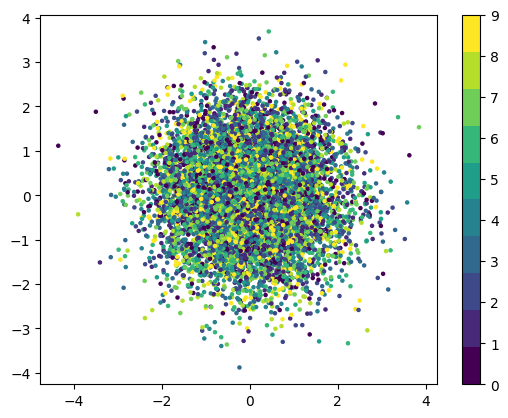

In [ ]:
values = None
all_labels = []

with torch.no_grad():
  for imgs, labels in val_dl:
    imgs = imgs.to(device)
    all_labels.extend(list(labels.numpy()))
    mean, log_var = enc(imgs)
    latents = enc.reparameterize(mean, log_var)
    if values is None:
      values = latents.cpu()
    else:
      values = torch.vstack((values, latents.cpu()))


cmap = plt.get_cmap('viridis', 10)
scatter = plt.scatter(values[:, 0], values[:, 1], c=all_labels, cmap=cmap, s=5)
plt.colorbar(scatter)
plt.show()

In [ ]:
# Save values for plotting later
df = pd.DataFrame({'Latent1': values[:, 0], 'Latent2': values[:, 1], 'Label': all_labels})
df.to_csv('KL_div_only.csv', index=False)

Analyzing the distribution of compressed samples in the latent space reveals the effect of the KL divergence term: it forces the latent space to conform to a standard Gaussian distribution. This regularization ensures that the space remains well-structured, with points densely clustered around the origin and progressively sparser towards the edges. This smoothness promotes coherent interpolation between representations, enhancing the model's generative capabilities and interpretability. Thus, the KL divergence term acts as a regularization mechanism that balances fidelity to the data and adherence to a prior distribution, improving overall model performance.

Now that we have understood the effect of the KL divergence, we are ready to train the variational autoencoder on the ELBO loss function.

In [ ]:
def training_loop_ELBO(n_epochs, optimizer_enc, optimizer_dec, enc, dec, loss_fn, train_loader, val_loader, beta=1):
  train_loss = []
  val_loss = []

  k = 2
  std_normal_mu = torch.zeros(k).to(device)
  std_normal_var = torch.eye(k).to(device)

  for epoch  in range(1, n_epochs+1):
    train_epoch_loss = 0.0
    val_epoch_loss = 0.0

    for imgs, _ in train_loader:
      imgs = imgs.to(device)
      mean, log_var = enc(imgs)
      latents = enc.reparameterize(mean, log_var)
      outputs = dec(latents).to(device)

      kl_divergence_train = -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())
      loss_train = loss_fn(outputs, imgs) + beta*kl_divergence_train

      optimizer_enc.zero_grad()
      optimizer_dec.zero_grad()

      loss_train.backward()
      optimizer_enc.step()
      optimizer_dec.step()

      train_epoch_loss += loss_train.item()

    for imgs, _ in val_loader:
      imgs = imgs.to(device)
      mean, log_var = enc(imgs)
      latents = enc.reparameterize(mean, log_var)
      outputs = dec(latents).to(device)

      kl_divergence_val = -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())
      loss_val = loss_fn(outputs, imgs) + beta*kl_divergence_val
      val_epoch_loss += loss_val.item()


    print('{} Epoch {}, Training Loss {}, Validation Loss {}'.format(datetime.datetime.now(), epoch, train_epoch_loss / len(train_loader), val_epoch_loss / len(val_loader)))

    train_loss.append(train_epoch_loss / len(train_loader))
    val_loss.append(val_epoch_loss / len(val_loader))

  return train_loss, val_loss

In [ ]:
z_dim = 2
enc = Encoder_VAE(z_dim=z_dim).to(device)
dec = Decoder(z_dim=z_dim).to(device)

num_trainable_params_enc = sum(p.numel() for p in enc.parameters() if p.requires_grad)
num_trainable_params_dec = sum(p.numel() for p in dec.parameters() if p.requires_grad)

print(f"Number of trainable parameters in Encoder: {num_trainable_params_enc}")
print(f"Number of trainable parameters in Decoder: {num_trainable_params_dec}")

Number of trainable parameters in Encoder: 43428
Number of trainable parameters in Decoder: 43441


In [ ]:
optimizer_enc = torch.optim.Adam(enc.parameters(), lr=0.001)
optimizer_dec = torch.optim.Adam(dec.parameters(), lr=0.001)

_, _ = training_loop_ELBO(
          n_epochs = 15,
          optimizer_enc = optimizer_enc,
          optimizer_dec = optimizer_dec,
          enc = enc,
          dec = dec,
          loss_fn = nn.BCELoss(),
          train_loader = train_dl,
          val_loader = val_dl,
          beta = 0.0001
          )

2024-05-17 17:42:55.437284 Epoch 1, Training Loss 0.3387480223675569, Validation Loss 0.2599397045373917
2024-05-17 17:43:05.901356 Epoch 2, Training Loss 0.25039188615977764, Validation Loss 0.24919621214270593
2024-05-17 17:43:16.897126 Epoch 3, Training Loss 0.24494420133531095, Validation Loss 0.24587324053049087
2024-05-17 17:43:28.054653 Epoch 4, Training Loss 0.24202980905771254, Validation Loss 0.24318987771868705
2024-05-17 17:43:39.023965 Epoch 5, Training Loss 0.2398793308188518, Validation Loss 0.24137467980384827
2024-05-17 17:43:49.906480 Epoch 6, Training Loss 0.2378458812336127, Validation Loss 0.23897644370794296
2024-05-17 17:44:01.443734 Epoch 7, Training Loss 0.23615657448768615, Validation Loss 0.2378876270353794
2024-05-17 17:44:12.773887 Epoch 8, Training Loss 0.23502814317742984, Validation Loss 0.23781492114067077
2024-05-17 17:44:23.803495 Epoch 9, Training Loss 0.2342861664046844, Validation Loss 0.2355257238447666
2024-05-17 17:44:34.164814 Epoch 10, Trainin

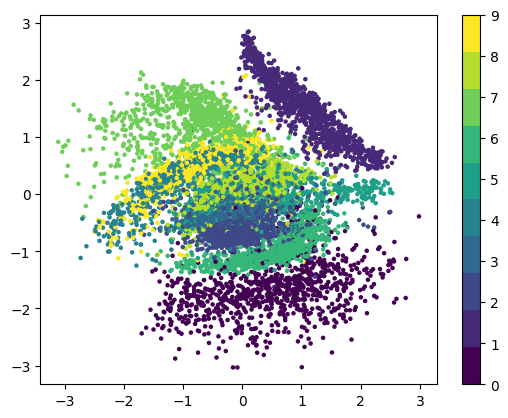

In [ ]:
values = None
all_labels = []

with torch.no_grad():
  for imgs, labels in val_dl:
    imgs = imgs.to(device)
    all_labels.extend(list(labels.numpy()))
    mean, log_var = enc(imgs)
    if values is None:
      values = mean.cpu()
    else:
      values = torch.vstack((values, mean.cpu()))


cmap = plt.get_cmap('viridis', 10)
scatter = plt.scatter(values[:, 0], values[:, 1], c=all_labels, cmap=cmap, s=5)
plt.colorbar(scatter)
plt.show()

In [ ]:
ranges = [np.linspace(-2.5, 2.5, 16),
          np.linspace(-2.5, 2.5, 16)]
samples = np.array(list(itertools.product(*ranges)))
with torch.no_grad():
  predictions = dec(torch.Tensor(samples).to(device)).cpu()
predictions.size()

torch.Size([256, 1, 28, 28])

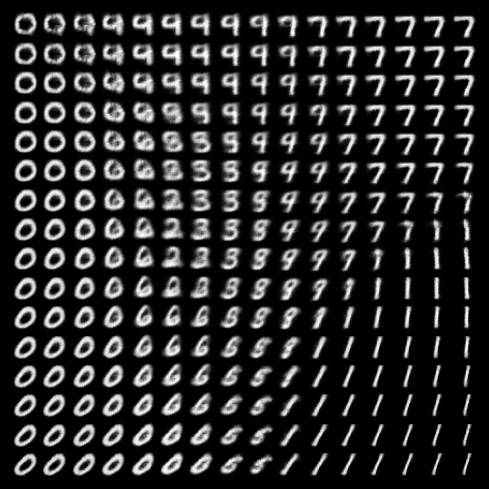

In [ ]:
n = int(np.sqrt(predictions.size(0)))
fig, ax = plt.subplots(n, n, figsize=(5, 5), gridspec_kw={'wspace': 0, 'hspace': 0}, facecolor='black')
ax_flat = ax.flatten()
for i in range(n**2):
    img = predictions[i, 0]
    ax = ax_flat[i]
    ax.imshow(img, cmap='gray')
    ax.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
# Save values for plotting later
df = pd.DataFrame({'Latent1': values[:, 0], 'Latent2': values[:, 1], 'Label': all_labels})
df.to_csv('reconstruction_KL_div.csv', index=False)

In [ ]:
# Save trained model
torch.save(enc, 'enc.pth')
torch.save(dec, 'dec.pth')

## Interactive plot

In [1]:
import mplcursors

In [3]:
# Import the CSV file using pandas
df = pd.read_csv('reconstruction_KL_div.csv')
values = df.iloc[:, :2].values
all_labels = df.iloc[:, 2].values

In [7]:
enc = torch.load('enc.pth', map_location=torch.device('cpu'))
dec = torch.load('dec.pth', map_location=torch.device('cpu'))

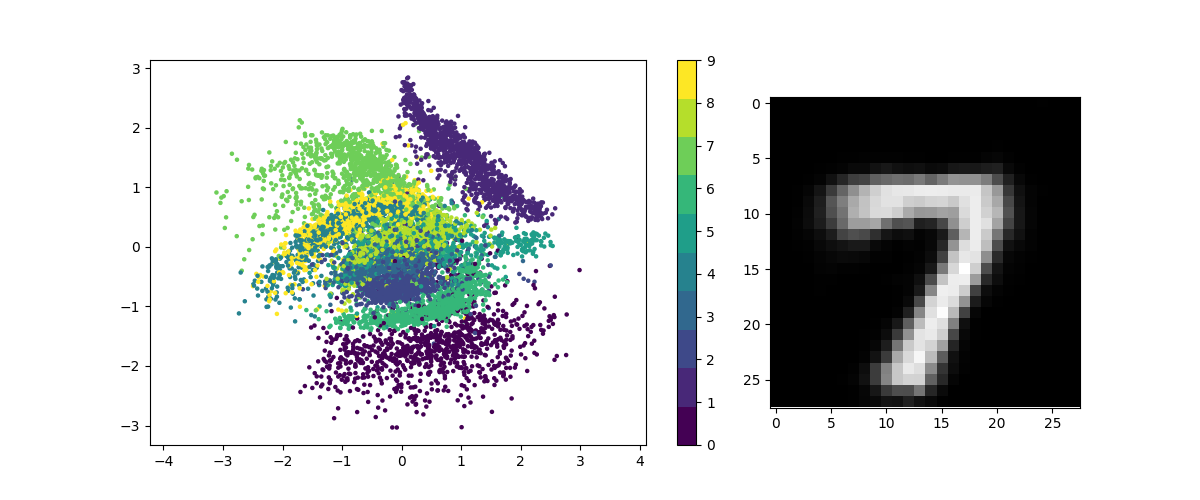

In [17]:
%matplotlib widget

def decode_image(sample):
    with torch.no_grad():
      pred = dec(torch.Tensor(sample).unsqueeze(0).to(device)).squeeze(0).cpu()

    return pred.permute(1, 2, 0)

def mouse_event(event):
    if event.inaxes:
        x, y = event.xdata, event.ydata
        decoded_image = decode_image([x, y])  # Feed x, y coordinates into decode_image
        ax2.imshow(decoded_image, cmap='gray')
        plt.draw()

fig, axs = plt.subplots(1, 2, figsize=(12, 5), gridspec_kw={'width_ratios': [2, 1]})
ax1, ax2 = axs

scatter = ax1.scatter(values[:, 0], values[:, 1], c=all_labels, cmap=plt.get_cmap('viridis', 10), s=5)
plt.colorbar(scatter)
ax1.axis('equal')

decoded_image = decode_image(values[0])
image_display = ax2.imshow(decoded_image, cmap='gray')

fig.canvas.mpl_connect('motion_notify_event', mouse_event)

plt.subplots_adjust(wspace=0)
plt.show()

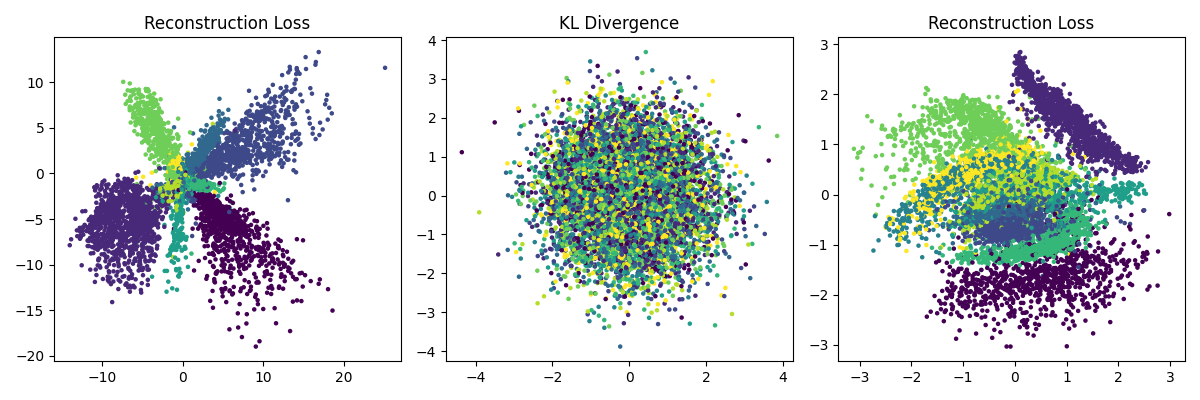

In [16]:
# Plot
# Normal autoencoder
AE_df = pd.read_csv('reconstruction_loss.csv')
VAE_KL_df = pd.read_csv('KL_div_only.csv')
VAE_df = pd.read_csv('reconstruction_KL_div.csv')

# Subplots
fig, axs = plt.subplots(1, 3, figsize=(12, 4))  # 1 row, 3 columns
cmap = plt.get_cmap('viridis', 10)

# Plot the first DataFrame
axs[0].scatter(AE_df['Latent1'], AE_df['Latent2'], c=AE_df['Label'], cmap=cmap, s=5)
axs[0].set_title('Reconstruction Loss')

# Plot the second DataFrame
axs[1].scatter(VAE_KL_df['Latent1'], VAE_KL_df['Latent2'], c=VAE_KL_df['Label'], cmap=cmap, s=5)
axs[1].set_title('KL Divergence')

# Plot the third DataFrame
axs[2].scatter(VAE_df['Latent1'], VAE_df['Latent2'], c=VAE_df['Label'], cmap=cmap, s=5)
axs[2].set_title('Reconstruction Loss')

plt.tight_layout()  # Adjust spacing to prevent overlap
plt.show()